In [1]:
import numpy as np
import corner

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

## Load data

In [3]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-3]
fit_betas = np.load("../data/fit_betas_P+B_new.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 7), (10500, 8))

## Train density estimators

In [4]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [5]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 8]),
 torch.Size([9975, 7]),
 torch.Size([525, 8]),
 torch.Size([525, 7]))

In [6]:
import torch.nn.functional as F

def get_flow(d_in=2, d_context=12, d_hidden=32, n_layers=4, dropout=0.1):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, 
                                                              hidden_features=d_hidden,
                                                              context_features=d_context,
                                                              use_residual_blocks=True,
                                                              dropout_probability=dropout,
                                                              activation=F.gelu))
        
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [7]:
def train_flow(flow, X, Y, X_val, Y_val, batch_size=64, n_steps=5001, n_eval_every=100, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    loss_train = []
    
    loss_train_accum = []
    loss_val_accum = []
    steps_accum = []

    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        if Y is not None:
            loss = -flow.log_prob(X[idxs,:], Y[idxs,:]).mean()
        else:
            loss = -flow.log_prob(X[idxs,:]).mean()

        loss.backward()
        optimizer.step()

        # Store loss
        loss_train.append(loss.item())

        # Print progress and validation loss
        if i_step % n_eval_every == 0:
            if Y is not None:
                loss_val = -flow.log_prob(X_val, Y_val).mean()
            else:
                loss_val = -flow.log_prob(X_val).mean()

            loss_train_accum.append(np.mean(loss_train))
            loss_val_accum.append(loss_val.item())
            steps_accum.append(i_step)

            print(f"Step {i_step}, loss: {np.mean(loss_train):.2f}, val loss: {loss_val.item():.2f}")

            loss_train = []

    return steps_accum, loss_train_accum, loss_val_accum
        

## $p(\beta\mid\mathrm{HOD})$

In [8]:
d_in = X_train.shape[-1]
d_context = Y_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=d_context, d_hidden=128, n_layers=8, dropout=0.1)

In [9]:
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, Y_train, X_val, Y_val, batch_size=128, n_steps=50001, n_eval_every=200, lr=3e-4)

  0%|          | 9/50001 [00:00<19:23, 42.96it/s]

Step 0, loss: 1622.85, val loss: 108.13


  0%|          | 207/50001 [00:04<16:30, 50.27it/s]

Step 200, loss: 17.96, val loss: 4.97


  1%|          | 411/50001 [00:07<16:01, 51.59it/s]

Step 400, loss: 1.88, val loss: 0.07


  1%|          | 609/50001 [00:11<15:36, 52.77it/s]

Step 600, loss: -1.22, val loss: -2.25


  2%|▏         | 807/50001 [00:15<15:34, 52.66it/s]

Step 800, loss: -3.12, val loss: -3.00


  2%|▏         | 1011/50001 [00:18<15:22, 53.12it/s]

Step 1000, loss: -4.39, val loss: -4.61


  2%|▏         | 1209/50001 [00:22<15:17, 53.18it/s]

Step 1200, loss: -5.33, val loss: -5.75


  3%|▎         | 1407/50001 [00:26<15:46, 51.34it/s]

Step 1400, loss: -6.16, val loss: -6.54


  3%|▎         | 1611/50001 [00:30<15:19, 52.60it/s]

Step 1600, loss: -6.81, val loss: -6.88


  4%|▎         | 1809/50001 [00:33<15:07, 53.10it/s]

Step 1800, loss: -7.49, val loss: -8.07


  4%|▍         | 2007/50001 [00:37<15:24, 51.91it/s]

Step 2000, loss: -8.06, val loss: -8.36


  4%|▍         | 2211/50001 [00:41<14:53, 53.50it/s]

Step 2200, loss: -8.59, val loss: -8.82


  5%|▍         | 2409/50001 [00:44<15:02, 52.75it/s]

Step 2400, loss: -8.98, val loss: -9.52


  5%|▌         | 2607/50001 [00:48<14:56, 52.87it/s]

Step 2600, loss: -9.44, val loss: -9.41


  6%|▌         | 2811/50001 [00:52<14:59, 52.46it/s]

Step 2800, loss: -9.76, val loss: -9.15


  6%|▌         | 3005/50001 [00:56<17:34, 44.57it/s]

Step 3000, loss: -9.93, val loss: -10.46


  6%|▋         | 3208/50001 [01:00<14:56, 52.17it/s]

Step 3200, loss: -10.23, val loss: -10.29


  7%|▋         | 3406/50001 [01:03<14:55, 52.03it/s]

Step 3400, loss: -10.52, val loss: -10.81


  7%|▋         | 3610/50001 [01:07<14:43, 52.51it/s]

Step 3600, loss: -10.76, val loss: -11.01


  8%|▊         | 3808/50001 [01:11<15:01, 51.23it/s]

Step 3800, loss: -10.86, val loss: -10.89


  8%|▊         | 4006/50001 [01:15<16:08, 47.47it/s]

Step 4000, loss: -11.12, val loss: -11.33


  8%|▊         | 4210/50001 [01:18<14:34, 52.38it/s]

Step 4200, loss: -11.27, val loss: -11.45


  9%|▉         | 4408/50001 [01:22<14:27, 52.53it/s]

Step 4400, loss: -11.44, val loss: -11.65


  9%|▉         | 4606/50001 [01:26<14:47, 51.16it/s]

Step 4600, loss: -11.56, val loss: -11.66


 10%|▉         | 4810/50001 [01:30<14:54, 50.52it/s]

Step 4800, loss: -11.67, val loss: -11.94


 10%|█         | 5008/50001 [01:33<14:05, 53.20it/s]

Step 5000, loss: -11.86, val loss: -10.07


 10%|█         | 5212/50001 [01:37<14:01, 53.22it/s]

Step 5200, loss: -11.93, val loss: -12.17


 11%|█         | 5410/50001 [01:41<14:01, 52.99it/s]

Step 5400, loss: -12.20, val loss: -12.32


 11%|█         | 5608/50001 [01:44<14:00, 52.79it/s]

Step 5600, loss: -12.16, val loss: -11.80


 12%|█▏        | 5812/50001 [01:48<13:53, 53.03it/s]

Step 5800, loss: -12.38, val loss: -12.14


 12%|█▏        | 6010/50001 [01:52<13:44, 53.33it/s]

Step 6000, loss: -12.34, val loss: -12.67


 12%|█▏        | 6208/50001 [01:56<13:57, 52.30it/s]

Step 6200, loss: -12.52, val loss: -12.26


 13%|█▎        | 6406/50001 [01:59<14:19, 50.73it/s]

Step 6400, loss: -12.60, val loss: -12.48


 13%|█▎        | 6610/50001 [02:03<13:35, 53.22it/s]

Step 6600, loss: -12.72, val loss: -12.34


 14%|█▎        | 6808/50001 [02:07<13:43, 52.45it/s]

Step 6800, loss: -12.77, val loss: -12.52


 14%|█▍        | 7006/50001 [02:10<14:56, 47.93it/s]

Step 7000, loss: -12.88, val loss: -12.94


 14%|█▍        | 7210/50001 [02:14<13:31, 52.76it/s]

Step 7200, loss: -13.07, val loss: -13.30


 15%|█▍        | 7408/50001 [02:18<13:32, 52.42it/s]

Step 7400, loss: -13.03, val loss: -12.89


 15%|█▌        | 7606/50001 [02:22<13:29, 52.39it/s]

Step 7600, loss: -13.25, val loss: -12.58


 16%|█▌        | 7810/50001 [02:25<13:18, 52.87it/s]

Step 7800, loss: -13.25, val loss: -13.44


 16%|█▌        | 8008/50001 [02:29<13:15, 52.79it/s]

Step 8000, loss: -13.38, val loss: -13.34


 16%|█▋        | 8206/50001 [02:33<13:21, 52.16it/s]

Step 8200, loss: -13.35, val loss: -13.32


 17%|█▋        | 8410/50001 [02:36<13:02, 53.12it/s]

Step 8400, loss: -13.60, val loss: -13.33


 17%|█▋        | 8608/50001 [02:40<13:36, 50.69it/s]

Step 8600, loss: -13.53, val loss: -13.32


 18%|█▊        | 8806/50001 [02:44<13:18, 51.59it/s]

Step 8800, loss: -13.72, val loss: -13.31


 18%|█▊        | 9010/50001 [02:48<12:55, 52.84it/s]

Step 9000, loss: -13.75, val loss: -13.86


 18%|█▊        | 9208/50001 [02:51<12:49, 53.00it/s]

Step 9200, loss: -13.70, val loss: -13.59


 19%|█▉        | 9412/50001 [02:55<12:49, 52.78it/s]

Step 9400, loss: -13.87, val loss: -13.70


 19%|█▉        | 9610/50001 [02:59<12:39, 53.19it/s]

Step 9600, loss: -13.86, val loss: -13.51


 20%|█▉        | 9808/50001 [03:02<12:40, 52.84it/s]

Step 9800, loss: -13.99, val loss: -13.60


 20%|██        | 10012/50001 [03:06<12:29, 53.38it/s]

Step 10000, loss: -14.05, val loss: -14.14


 20%|██        | 10210/50001 [03:10<12:29, 53.06it/s]

Step 10200, loss: -14.10, val loss: -13.95


 21%|██        | 10408/50001 [03:13<12:25, 53.12it/s]

Step 10400, loss: -14.14, val loss: -13.69


 21%|██        | 10612/50001 [03:17<12:22, 53.02it/s]

Step 10600, loss: -14.20, val loss: -13.75


 22%|██▏       | 10810/50001 [03:21<12:21, 52.84it/s]

Step 10800, loss: -14.30, val loss: -14.32


 22%|██▏       | 11008/50001 [03:24<12:19, 52.75it/s]

Step 11000, loss: -14.37, val loss: -14.31


 22%|██▏       | 11206/50001 [03:28<12:19, 52.43it/s]

Step 11200, loss: -14.38, val loss: -14.39


 23%|██▎       | 11410/50001 [03:32<12:07, 53.08it/s]

Step 11400, loss: -14.47, val loss: -14.35


 23%|██▎       | 11608/50001 [03:36<12:01, 53.22it/s]

Step 11600, loss: -14.49, val loss: -13.59


 24%|██▎       | 11806/50001 [03:39<12:05, 52.66it/s]

Step 11800, loss: -14.43, val loss: -14.18


 24%|██▍       | 12010/50001 [03:43<11:56, 53.06it/s]

Step 12000, loss: -14.56, val loss: -14.35


 24%|██▍       | 12208/50001 [03:47<11:57, 52.70it/s]

Step 12200, loss: -14.64, val loss: -14.64


 25%|██▍       | 12412/50001 [03:50<11:48, 53.05it/s]

Step 12400, loss: -14.69, val loss: -14.86


 25%|██▌       | 12610/50001 [03:54<11:41, 53.28it/s]

Step 12600, loss: -14.64, val loss: -14.35


 26%|██▌       | 12808/50001 [03:58<12:18, 50.38it/s]

Step 12800, loss: -14.74, val loss: -14.36


 26%|██▌       | 13006/50001 [04:02<12:12, 50.48it/s]

Step 13000, loss: -14.88, val loss: -14.63


 26%|██▋       | 13210/50001 [04:05<11:39, 52.56it/s]

Step 13200, loss: -14.80, val loss: -14.30


 27%|██▋       | 13408/50001 [04:09<11:34, 52.66it/s]

Step 13400, loss: -14.89, val loss: -14.64


 27%|██▋       | 13612/50001 [04:13<11:27, 52.91it/s]

Step 13600, loss: -14.98, val loss: -14.94


 28%|██▊       | 13810/50001 [04:17<11:28, 52.59it/s]

Step 13800, loss: -15.02, val loss: -14.88


 28%|██▊       | 14008/50001 [04:20<11:14, 53.39it/s]

Step 14000, loss: -15.10, val loss: -15.04


 28%|██▊       | 14206/50001 [04:24<11:31, 51.76it/s]

Step 14200, loss: -15.01, val loss: -14.87


 29%|██▉       | 14410/50001 [04:28<11:55, 49.71it/s]

Step 14400, loss: -15.07, val loss: -14.23


 29%|██▉       | 14608/50001 [04:32<11:25, 51.61it/s]

Step 14600, loss: -15.15, val loss: -14.37


 30%|██▉       | 14812/50001 [04:35<11:05, 52.85it/s]

Step 14800, loss: -15.17, val loss: -14.85


 30%|███       | 15010/50001 [04:39<11:07, 52.43it/s]

Step 15000, loss: -15.08, val loss: -15.13


 30%|███       | 15208/50001 [04:43<11:05, 52.28it/s]

Step 15200, loss: -15.29, val loss: -15.21


 31%|███       | 15406/50001 [04:46<11:04, 52.07it/s]

Step 15400, loss: -15.35, val loss: -15.12


 31%|███       | 15610/50001 [04:50<11:01, 52.02it/s]

Step 15600, loss: -15.37, val loss: -14.80


 32%|███▏      | 15808/50001 [04:54<10:51, 52.51it/s]

Step 15800, loss: -15.42, val loss: -15.19


 32%|███▏      | 16006/50001 [04:57<11:03, 51.23it/s]

Step 16000, loss: -15.40, val loss: -15.31


 32%|███▏      | 16210/50001 [05:01<10:54, 51.62it/s]

Step 16200, loss: -15.47, val loss: -15.52


 33%|███▎      | 16408/50001 [05:05<10:54, 51.33it/s]

Step 16400, loss: -15.59, val loss: -15.38


 33%|███▎      | 16606/50001 [05:09<10:52, 51.19it/s]

Step 16600, loss: -15.57, val loss: -15.35


 34%|███▎      | 16810/50001 [05:13<10:32, 52.46it/s]

Step 16800, loss: -15.67, val loss: -14.89


 34%|███▍      | 17008/50001 [05:16<10:22, 52.97it/s]

Step 17000, loss: -15.58, val loss: -15.55


 34%|███▍      | 17212/50001 [05:20<10:16, 53.18it/s]

Step 17200, loss: -15.71, val loss: -15.08


 35%|███▍      | 17410/50001 [05:24<10:17, 52.78it/s]

Step 17400, loss: -15.76, val loss: -15.58


 35%|███▌      | 17608/50001 [05:27<10:13, 52.83it/s]

Step 17600, loss: -15.77, val loss: -15.30


 36%|███▌      | 17806/50001 [05:31<10:19, 51.98it/s]

Step 17800, loss: -15.84, val loss: -15.75


 36%|███▌      | 18010/50001 [05:35<10:21, 51.50it/s]

Step 18000, loss: -15.85, val loss: -15.92


 36%|███▋      | 18208/50001 [05:38<10:01, 52.89it/s]

Step 18200, loss: -15.96, val loss: -15.38


 37%|███▋      | 18406/50001 [05:42<10:12, 51.61it/s]

Step 18400, loss: -15.96, val loss: -15.97


 37%|███▋      | 18610/50001 [05:46<10:00, 52.26it/s]

Step 18600, loss: -16.03, val loss: -15.62


 38%|███▊      | 18808/50001 [05:49<09:48, 52.97it/s]

Step 18800, loss: -16.10, val loss: -15.13


 38%|███▊      | 19006/50001 [05:53<09:48, 52.66it/s]

Step 19000, loss: -16.17, val loss: -15.54


 38%|███▊      | 19210/50001 [05:57<09:42, 52.88it/s]

Step 19200, loss: -16.02, val loss: -16.09


 39%|███▉      | 19408/50001 [06:01<09:41, 52.60it/s]

Step 19400, loss: -16.27, val loss: -16.25


 39%|███▉      | 19606/50001 [06:04<09:42, 52.20it/s]

Step 19600, loss: -16.25, val loss: -15.57


 40%|███▉      | 19810/50001 [06:08<09:34, 52.56it/s]

Step 19800, loss: -16.31, val loss: -16.24


 40%|████      | 20008/50001 [06:12<09:30, 52.62it/s]

Step 20000, loss: -16.39, val loss: -16.15


 40%|████      | 20212/50001 [06:15<09:25, 52.68it/s]

Step 20200, loss: -16.39, val loss: -16.19


 41%|████      | 20410/50001 [06:19<09:25, 52.31it/s]

Step 20400, loss: -16.47, val loss: -16.33


 41%|████      | 20608/50001 [06:23<09:18, 52.62it/s]

Step 20600, loss: -16.48, val loss: -16.34


 42%|████▏     | 20812/50001 [06:27<09:13, 52.74it/s]

Step 20800, loss: -16.61, val loss: -16.39


 42%|████▏     | 21010/50001 [06:30<09:15, 52.21it/s]

Step 21000, loss: -16.61, val loss: -16.61


 42%|████▏     | 21208/50001 [06:34<09:10, 52.27it/s]

Step 21200, loss: -16.56, val loss: -15.92


 43%|████▎     | 21406/50001 [06:38<09:09, 52.07it/s]

Step 21400, loss: -16.76, val loss: -16.65


 43%|████▎     | 21610/50001 [06:41<08:53, 53.22it/s]

Step 21600, loss: -16.63, val loss: -16.57


 44%|████▎     | 21808/50001 [06:45<08:54, 52.79it/s]

Step 21800, loss: -16.73, val loss: -16.59


 44%|████▍     | 22006/50001 [06:49<08:57, 52.12it/s]

Step 22000, loss: -16.84, val loss: -16.80


 44%|████▍     | 22210/50001 [06:52<08:46, 52.78it/s]

Step 22200, loss: -16.80, val loss: -16.69


 45%|████▍     | 22408/50001 [06:56<08:41, 52.91it/s]

Step 22400, loss: -16.83, val loss: -16.59


 45%|████▌     | 22606/50001 [07:00<08:45, 52.14it/s]

Step 22600, loss: -16.94, val loss: -16.55


 46%|████▌     | 22810/50001 [07:03<08:30, 53.21it/s]

Step 22800, loss: -16.98, val loss: -16.62


 46%|████▌     | 23008/50001 [07:07<08:29, 52.99it/s]

Step 23000, loss: -17.05, val loss: -16.71


 46%|████▋     | 23212/50001 [07:11<08:29, 52.54it/s]

Step 23200, loss: -16.84, val loss: -17.29


 47%|████▋     | 23410/50001 [07:15<08:24, 52.74it/s]

Step 23400, loss: -16.97, val loss: -15.86


 47%|████▋     | 23608/50001 [07:18<08:24, 52.28it/s]

Step 23600, loss: -16.95, val loss: -17.00


 48%|████▊     | 23812/50001 [07:22<08:12, 53.20it/s]

Step 23800, loss: -17.19, val loss: -17.01


 48%|████▊     | 24010/50001 [07:26<08:06, 53.47it/s]

Step 24000, loss: -17.21, val loss: -15.89


 48%|████▊     | 24208/50001 [07:29<08:14, 52.11it/s]

Step 24200, loss: -17.05, val loss: -16.88


 49%|████▉     | 24406/50001 [07:33<08:11, 52.06it/s]

Step 24400, loss: -17.17, val loss: -17.21


 49%|████▉     | 24610/50001 [07:37<08:00, 52.83it/s]

Step 24600, loss: -17.18, val loss: -17.14


 50%|████▉     | 24808/50001 [07:40<07:54, 53.09it/s]

Step 24800, loss: -17.23, val loss: -15.59


 50%|█████     | 25012/50001 [07:44<07:51, 52.97it/s]

Step 25000, loss: -17.32, val loss: -17.11


 50%|█████     | 25210/50001 [07:48<07:49, 52.78it/s]

Step 25200, loss: -17.24, val loss: -16.83


 51%|█████     | 25408/50001 [07:51<07:45, 52.79it/s]

Step 25400, loss: -17.30, val loss: -16.82


 51%|█████     | 25606/50001 [07:55<07:47, 52.14it/s]

Step 25600, loss: -17.30, val loss: -17.11


 52%|█████▏    | 25810/50001 [07:59<07:35, 53.13it/s]

Step 25800, loss: -17.39, val loss: -17.26


 52%|█████▏    | 26008/50001 [08:03<07:35, 52.62it/s]

Step 26000, loss: -17.47, val loss: -17.30


 52%|█████▏    | 26206/50001 [08:06<07:43, 51.31it/s]

Step 26200, loss: -17.33, val loss: -16.96


 53%|█████▎    | 26410/50001 [08:10<07:31, 52.28it/s]

Step 26400, loss: -17.53, val loss: -16.88


 53%|█████▎    | 26608/50001 [08:14<07:20, 53.08it/s]

Step 26600, loss: -17.44, val loss: -17.42


 54%|█████▎    | 26812/50001 [08:18<07:20, 52.68it/s]

Step 26800, loss: -17.46, val loss: -17.02


 54%|█████▍    | 27009/50001 [08:21<07:25, 51.56it/s]

Step 27000, loss: -17.52, val loss: -17.35


 54%|█████▍    | 27207/50001 [08:25<07:12, 52.73it/s]

Step 27200, loss: -17.61, val loss: -17.15


 55%|█████▍    | 27411/50001 [08:29<07:08, 52.76it/s]

Step 27400, loss: -17.52, val loss: -17.07


 55%|█████▌    | 27609/50001 [08:33<07:04, 52.78it/s]

Step 27600, loss: -17.65, val loss: -17.00


 56%|█████▌    | 27807/50001 [08:36<07:09, 51.62it/s]

Step 27800, loss: -17.52, val loss: -17.70


 56%|█████▌    | 28011/50001 [08:40<06:52, 53.25it/s]

Step 28000, loss: -17.68, val loss: -17.51


 56%|█████▋    | 28209/50001 [08:44<06:50, 53.04it/s]

Step 28200, loss: -17.63, val loss: -17.04


 57%|█████▋    | 28407/50001 [08:47<06:46, 53.09it/s]

Step 28400, loss: -17.73, val loss: -17.50


 57%|█████▋    | 28611/50001 [08:51<06:44, 52.85it/s]

Step 28600, loss: -17.70, val loss: -17.63


 58%|█████▊    | 28809/50001 [08:55<06:37, 53.25it/s]

Step 28800, loss: -17.75, val loss: -17.11


 58%|█████▊    | 29007/50001 [08:59<06:46, 51.67it/s]

Step 29000, loss: -17.78, val loss: -17.34


 58%|█████▊    | 29211/50001 [09:02<06:36, 52.40it/s]

Step 29200, loss: -17.79, val loss: -17.58


 59%|█████▉    | 29409/50001 [09:06<06:28, 52.95it/s]

Step 29400, loss: -17.82, val loss: -17.74


 59%|█████▉    | 29607/50001 [09:10<06:25, 52.84it/s]

Step 29600, loss: -17.77, val loss: -17.61


 60%|█████▉    | 29811/50001 [09:14<06:47, 49.60it/s]

Step 29800, loss: -17.91, val loss: -17.74


 60%|██████    | 30009/50001 [09:17<06:26, 51.71it/s]

Step 30000, loss: -18.01, val loss: -17.84


 60%|██████    | 30207/50001 [09:21<06:21, 51.86it/s]

Step 30200, loss: -17.79, val loss: -17.52


 61%|██████    | 30411/50001 [09:25<06:13, 52.39it/s]

Step 30400, loss: -17.90, val loss: -17.65


 61%|██████    | 30609/50001 [09:29<06:10, 52.32it/s]

Step 30600, loss: -17.94, val loss: -17.25


 62%|██████▏   | 30807/50001 [09:32<06:08, 52.07it/s]

Step 30800, loss: -17.99, val loss: -17.80


 62%|██████▏   | 31011/50001 [09:36<05:58, 52.97it/s]

Step 31000, loss: -18.04, val loss: -17.90


 62%|██████▏   | 31209/50001 [09:40<05:52, 53.35it/s]

Step 31200, loss: -18.03, val loss: -17.90


 63%|██████▎   | 31407/50001 [09:43<05:50, 53.08it/s]

Step 31400, loss: -17.94, val loss: -17.38


 63%|██████▎   | 31611/50001 [09:47<05:39, 54.11it/s]

Step 31600, loss: -18.09, val loss: -18.19


 64%|██████▎   | 31809/50001 [09:51<05:47, 52.34it/s]

Step 31800, loss: -18.09, val loss: -17.63


 64%|██████▍   | 32007/50001 [09:54<05:43, 52.34it/s]

Step 32000, loss: -18.18, val loss: -17.45


 64%|██████▍   | 32211/50001 [09:58<05:38, 52.50it/s]

Step 32200, loss: -18.00, val loss: -18.01


 65%|██████▍   | 32409/50001 [10:02<05:34, 52.63it/s]

Step 32400, loss: -18.24, val loss: -18.09


 65%|██████▌   | 32607/50001 [10:06<05:35, 51.80it/s]

Step 32600, loss: -18.12, val loss: -17.94


 66%|██████▌   | 32807/50001 [10:10<05:56, 48.20it/s]

Step 32800, loss: -18.12, val loss: -17.20


 66%|██████▌   | 33011/50001 [10:13<05:19, 53.11it/s]

Step 33000, loss: -18.19, val loss: -17.57


 66%|██████▋   | 33209/50001 [10:17<05:18, 52.74it/s]

Step 33200, loss: -18.09, val loss: -17.84


 67%|██████▋   | 33407/50001 [10:21<05:15, 52.59it/s]

Step 33400, loss: -18.19, val loss: -18.39


 67%|██████▋   | 33611/50001 [10:25<05:09, 52.90it/s]

Step 33600, loss: -18.30, val loss: -17.98


 68%|██████▊   | 33809/50001 [10:28<05:05, 53.07it/s]

Step 33800, loss: -18.25, val loss: -18.34


 68%|██████▊   | 34007/50001 [10:32<05:03, 52.74it/s]

Step 34000, loss: -18.29, val loss: -18.17


 68%|██████▊   | 34211/50001 [10:36<04:57, 53.13it/s]

Step 34200, loss: -18.26, val loss: -17.74


 69%|██████▉   | 34409/50001 [10:39<05:03, 51.45it/s]

Step 34400, loss: -18.32, val loss: -18.11


 69%|██████▉   | 34607/50001 [10:43<04:49, 53.10it/s]

Step 34600, loss: -18.24, val loss: -18.20


 70%|██████▉   | 34811/50001 [10:47<04:47, 52.82it/s]

Step 34800, loss: -18.31, val loss: -18.02


 70%|███████   | 35009/50001 [10:51<04:45, 52.56it/s]

Step 35000, loss: -18.30, val loss: -17.92


 70%|███████   | 35207/50001 [10:54<04:41, 52.49it/s]

Step 35200, loss: -18.31, val loss: -18.38


 71%|███████   | 35411/50001 [10:58<04:45, 51.18it/s]

Step 35400, loss: -18.41, val loss: -18.25


 71%|███████   | 35609/50001 [11:02<04:40, 51.37it/s]

Step 35600, loss: -18.49, val loss: -18.05


 72%|███████▏  | 35807/50001 [11:06<04:26, 53.21it/s]

Step 35800, loss: -18.37, val loss: -18.42


 72%|███████▏  | 36011/50001 [11:09<04:21, 53.40it/s]

Step 36000, loss: -18.50, val loss: -18.10


 72%|███████▏  | 36209/50001 [11:13<04:19, 53.13it/s]

Step 36200, loss: -18.49, val loss: -18.08


 73%|███████▎  | 36407/50001 [11:17<04:19, 52.34it/s]

Step 36400, loss: -18.52, val loss: -18.09


 73%|███████▎  | 36610/50001 [11:21<04:15, 52.44it/s]

Step 36600, loss: -18.50, val loss: -17.95


 74%|███████▎  | 36808/50001 [11:24<04:12, 52.25it/s]

Step 36800, loss: -18.48, val loss: -18.13


 74%|███████▍  | 37012/50001 [11:28<04:05, 52.87it/s]

Step 37000, loss: -18.54, val loss: -18.57


 74%|███████▍  | 37210/50001 [11:32<04:14, 50.33it/s]

Step 37200, loss: -18.49, val loss: -17.32


 75%|███████▍  | 37408/50001 [11:36<03:59, 52.59it/s]

Step 37400, loss: -18.60, val loss: -18.30


 75%|███████▌  | 37606/50001 [11:39<04:01, 51.33it/s]

Step 37600, loss: -18.57, val loss: -17.79


 76%|███████▌  | 37810/50001 [11:43<03:50, 52.88it/s]

Step 37800, loss: -18.58, val loss: -18.12


 76%|███████▌  | 38008/50001 [11:47<03:54, 51.13it/s]

Step 38000, loss: -18.52, val loss: -17.38


 76%|███████▋  | 38211/50001 [11:51<03:50, 51.16it/s]

Step 38200, loss: -18.60, val loss: -18.34


 77%|███████▋  | 38409/50001 [11:54<03:46, 51.26it/s]

Step 38400, loss: -18.62, val loss: -18.22


 77%|███████▋  | 38607/50001 [11:58<03:40, 51.68it/s]

Step 38600, loss: -18.64, val loss: -18.39


 78%|███████▊  | 38811/50001 [12:02<03:34, 52.08it/s]

Step 38800, loss: -18.50, val loss: -18.64


 78%|███████▊  | 39009/50001 [12:06<03:31, 52.08it/s]

Step 39000, loss: -18.75, val loss: -17.70


 78%|███████▊  | 39207/50001 [12:09<03:27, 52.10it/s]

Step 39200, loss: -18.63, val loss: -18.53


 79%|███████▉  | 39411/50001 [12:13<03:23, 52.13it/s]

Step 39400, loss: -18.63, val loss: -18.41


 79%|███████▉  | 39609/50001 [12:17<03:18, 52.48it/s]

Step 39600, loss: -18.64, val loss: -18.77


 80%|███████▉  | 39807/50001 [12:21<03:17, 51.59it/s]

Step 39800, loss: -18.68, val loss: -18.45


 80%|████████  | 40011/50001 [12:25<03:15, 51.08it/s]

Step 40000, loss: -18.69, val loss: -18.55


 80%|████████  | 40208/50001 [12:29<03:12, 50.85it/s]

Step 40200, loss: -18.72, val loss: -18.60


 81%|████████  | 40406/50001 [12:32<03:08, 50.81it/s]

Step 40400, loss: -18.80, val loss: -18.48


 81%|████████  | 40610/50001 [12:36<02:59, 52.40it/s]

Step 40600, loss: -18.72, val loss: -17.53


 82%|████████▏ | 40808/50001 [12:40<03:00, 51.03it/s]

Step 40800, loss: -18.71, val loss: -18.47


 82%|████████▏ | 41006/50001 [12:44<02:53, 51.93it/s]

Step 41000, loss: -18.81, val loss: -18.02


 82%|████████▏ | 41210/50001 [12:48<02:46, 52.82it/s]

Step 41200, loss: -18.79, val loss: -18.20


 83%|████████▎ | 41408/50001 [12:51<02:43, 52.55it/s]

Step 41400, loss: -18.79, val loss: -17.94


 83%|████████▎ | 41606/50001 [12:55<02:45, 50.65it/s]

Step 41600, loss: -18.83, val loss: -18.63


 84%|████████▎ | 41810/50001 [12:59<02:36, 52.43it/s]

Step 41800, loss: -18.84, val loss: -17.90


 84%|████████▍ | 42008/50001 [13:03<02:32, 52.42it/s]

Step 42000, loss: -18.91, val loss: -18.81


 84%|████████▍ | 42206/50001 [13:06<02:31, 51.61it/s]

Step 42200, loss: -18.79, val loss: -18.16


 85%|████████▍ | 42410/50001 [13:10<02:26, 51.87it/s]

Step 42400, loss: -18.91, val loss: -17.90


 85%|████████▌ | 42608/50001 [13:14<02:20, 52.62it/s]

Step 42600, loss: -18.96, val loss: -18.52


 86%|████████▌ | 42812/50001 [13:18<02:16, 52.71it/s]

Step 42800, loss: -18.79, val loss: -18.88


 86%|████████▌ | 43010/50001 [13:21<02:12, 52.81it/s]

Step 43000, loss: -18.97, val loss: -18.61


 86%|████████▋ | 43208/50001 [13:25<02:09, 52.45it/s]

Step 43200, loss: -18.96, val loss: -18.98


 87%|████████▋ | 43412/50001 [13:29<02:06, 52.14it/s]

Step 43400, loss: -18.91, val loss: -18.80


 87%|████████▋ | 43610/50001 [13:32<02:01, 52.41it/s]

Step 43600, loss: -18.98, val loss: -18.89


 88%|████████▊ | 43808/50001 [13:36<01:57, 52.73it/s]

Step 43800, loss: -18.95, val loss: -18.32


 88%|████████▊ | 44006/50001 [13:40<01:55, 51.68it/s]

Step 44000, loss: -18.89, val loss: -18.70


 88%|████████▊ | 44210/50001 [13:43<01:49, 52.79it/s]

Step 44200, loss: -18.95, val loss: -18.67


 89%|████████▉ | 44408/50001 [13:47<01:46, 52.70it/s]

Step 44400, loss: -19.02, val loss: -18.39


 89%|████████▉ | 44606/50001 [13:51<01:48, 49.89it/s]

Step 44600, loss: -18.98, val loss: -19.06


 90%|████████▉ | 44810/50001 [13:55<01:38, 52.62it/s]

Step 44800, loss: -19.02, val loss: -18.55


 90%|█████████ | 45008/50001 [13:58<01:34, 52.72it/s]

Step 45000, loss: -18.99, val loss: -18.00


 90%|█████████ | 45212/50001 [14:02<01:30, 52.77it/s]

Step 45200, loss: -19.02, val loss: -18.77


 91%|█████████ | 45410/50001 [14:06<01:27, 52.64it/s]

Step 45400, loss: -19.10, val loss: -18.35


 91%|█████████ | 45608/50001 [14:09<01:23, 52.92it/s]

Step 45600, loss: -19.08, val loss: -18.57


 92%|█████████▏| 45806/50001 [14:13<01:20, 51.97it/s]

Step 45800, loss: -18.97, val loss: -17.96


 92%|█████████▏| 46010/50001 [14:17<01:15, 52.79it/s]

Step 46000, loss: -19.09, val loss: -18.77


 92%|█████████▏| 46208/50001 [14:21<01:12, 52.59it/s]

Step 46200, loss: -19.11, val loss: -18.89


 93%|█████████▎| 46406/50001 [14:24<01:09, 51.53it/s]

Step 46400, loss: -18.98, val loss: -18.59


 93%|█████████▎| 46610/50001 [14:28<01:04, 52.86it/s]

Step 46600, loss: -19.12, val loss: -18.71


 94%|█████████▎| 46808/50001 [14:32<01:00, 52.78it/s]

Step 46800, loss: -19.16, val loss: -18.48


 94%|█████████▍| 47006/50001 [14:35<00:57, 51.71it/s]

Step 47000, loss: -19.06, val loss: -18.70


 94%|█████████▍| 47210/50001 [14:39<00:53, 52.31it/s]

Step 47200, loss: -19.19, val loss: -18.13


 95%|█████████▍| 47408/50001 [14:43<00:49, 52.43it/s]

Step 47400, loss: -19.13, val loss: -18.60


 95%|█████████▌| 47606/50001 [14:46<00:46, 52.03it/s]

Step 47600, loss: -19.02, val loss: -18.91


 96%|█████████▌| 47810/50001 [14:50<00:41, 52.45it/s]

Step 47800, loss: -19.21, val loss: -18.29


 96%|█████████▌| 48008/50001 [14:54<00:37, 52.75it/s]

Step 48000, loss: -19.24, val loss: -18.78


 96%|█████████▋| 48212/50001 [14:58<00:33, 52.75it/s]

Step 48200, loss: -19.19, val loss: -18.88


 97%|█████████▋| 48410/50001 [15:01<00:29, 53.07it/s]

Step 48400, loss: -19.20, val loss: -19.09


 97%|█████████▋| 48608/50001 [15:05<00:26, 52.67it/s]

Step 48600, loss: -19.11, val loss: -18.24


 98%|█████████▊| 48812/50001 [15:09<00:22, 52.87it/s]

Step 48800, loss: -19.10, val loss: -18.46


 98%|█████████▊| 49010/50001 [15:12<00:18, 52.80it/s]

Step 49000, loss: -19.31, val loss: -18.63


 98%|█████████▊| 49208/50001 [15:16<00:15, 52.57it/s]

Step 49200, loss: -19.23, val loss: -19.17


 99%|█████████▉| 49406/50001 [15:20<00:11, 52.30it/s]

Step 49400, loss: -19.16, val loss: -17.83


 99%|█████████▉| 49610/50001 [15:24<00:07, 52.61it/s]

Step 49600, loss: -19.28, val loss: -19.20


100%|█████████▉| 49808/50001 [15:27<00:03, 50.77it/s]

Step 49800, loss: -19.20, val loss: -17.44


100%|██████████| 50001/50001 [15:31<00:00, 53.68it/s]

Step 50000, loss: -19.32, val loss: -18.87


In [10]:
flow.eval();

In [11]:
Y_val.mean(axis=0), Y_val.std(axis=0)

(tensor([ 1.2860e+01,  1.3784e+01, -1.5061e+00,  1.0984e+00,  7.3336e-01,
         -1.5780e-04, -1.7786e-02]),
 tensor([0.2566, 0.3379, 0.8555, 0.2232, 0.4327, 0.2798, 0.5767]))

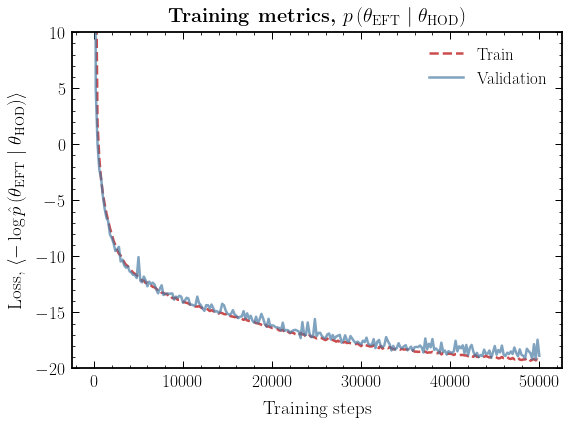

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-20, 10)
plt.tight_layout()
plt.savefig("figures/loss_p_eft_hod.pdf")

In [14]:
samples_1 = flow.sample(context=(Y_val.mean(0) - 0 * Y_val.std(0)) [None, ...], num_samples=10_000)
samples_2 = flow.sample(context=(Y_val.mean(0) + 1 * Y_val.std(0)) [None, ...], num_samples=10_000)

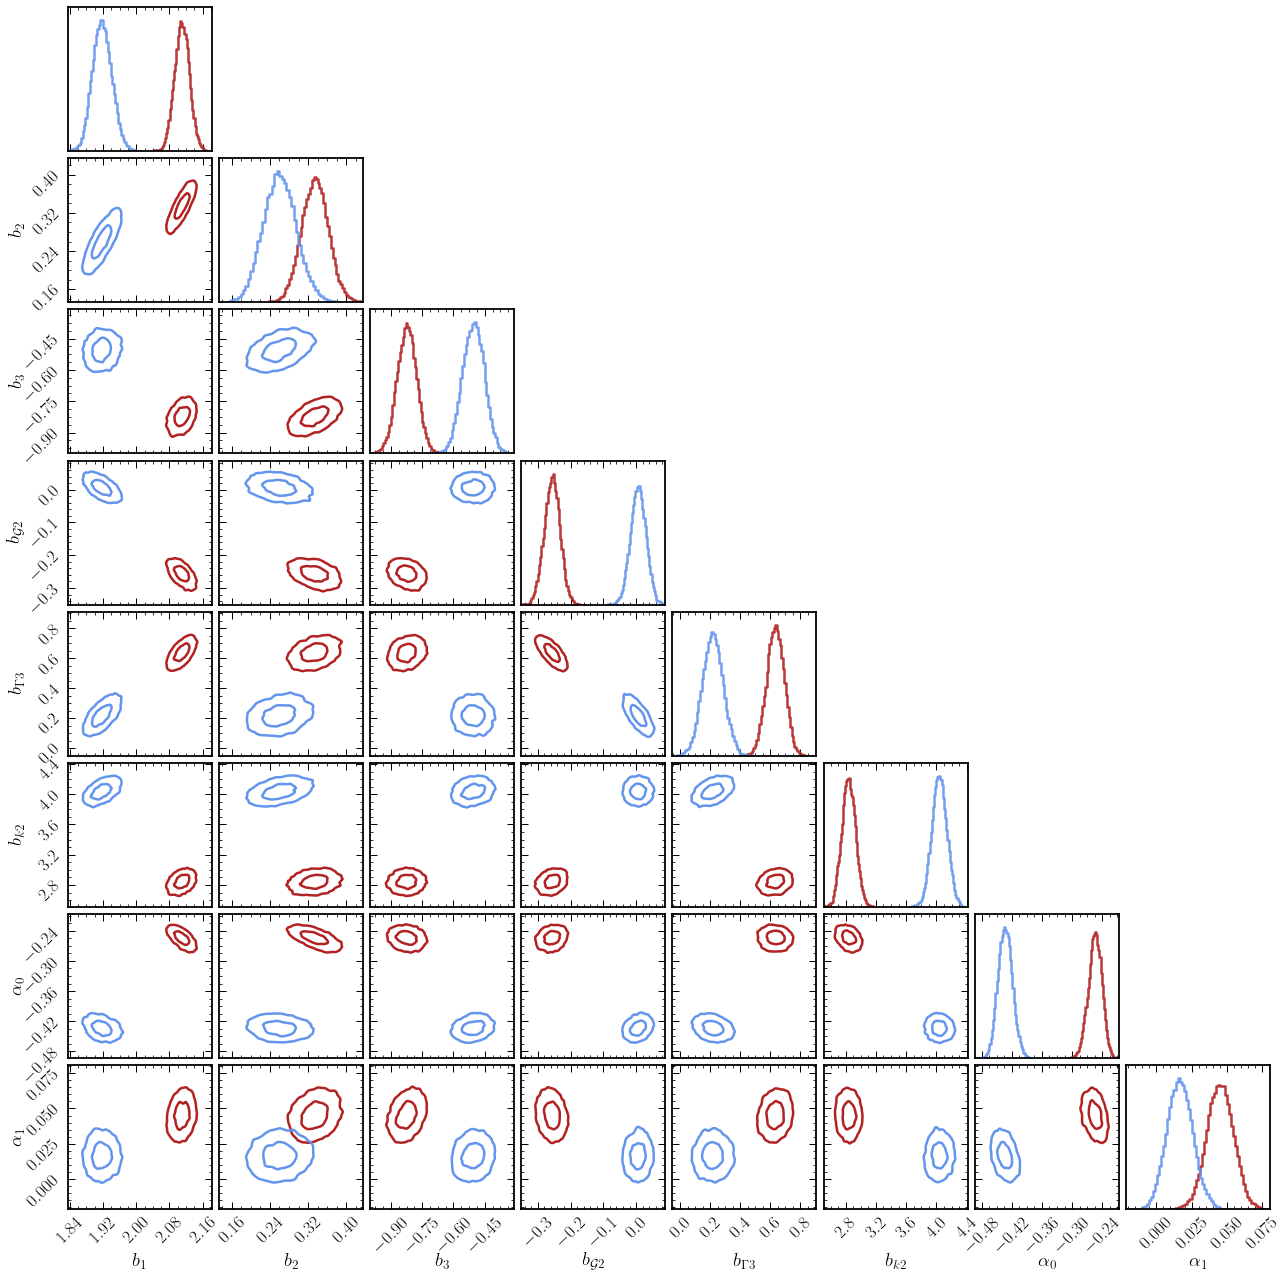

In [15]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 1.,
    "smooth1d": 0.75,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": False,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$', r"$\alpha_0$", r"$\alpha_1$",]
}

fig = corner.corner(samples_1.detach().numpy(), **corner_configs, color='firebrick');
corner.corner(samples_2.detach().numpy(), **corner_configs, fig=fig, color='cornflowerblue');

In [12]:
torch.save(flow, "../data/models/p_beta_hod.pt")

## $p(\beta)$

In [44]:
fit_betas.shape

In [45]:
# remove b3 and bk2 (index 2 and 5) from betas
fit_betas = fit_betas[:, [0, 1, 3, 4]]

In [46]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 4]),
 torch.Size([9975, 7]),
 torch.Size([525, 4]),
 torch.Size([525, 7]))

In [47]:
d_in = X_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=0, d_hidden=64, n_layers=6, dropout=0.1)
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, None, X_val, None, batch_size=128, n_steps=30001, n_eval_every=200, lr=3e-4)

  0%|          | 0/30001 [00:00<?, ?it/s]

  0%|          | 18/30001 [00:00<05:22, 92.95it/s]

Step 0, loss: 13.19, val loss: 13.09


  1%|          | 218/30001 [00:01<03:50, 129.24it/s]

Step 200, loss: 3.32, val loss: -0.30


  1%|▏         | 425/30001 [00:03<04:06, 119.86it/s]

Step 400, loss: -0.43, val loss: -0.57


  2%|▏         | 625/30001 [00:04<03:59, 122.80it/s]

Step 600, loss: -0.63, val loss: -0.71


  3%|▎         | 818/30001 [00:06<03:51, 125.82it/s]

Step 800, loss: -0.76, val loss: -0.82


  3%|▎         | 1024/30001 [00:08<03:45, 128.55it/s]

Step 1000, loss: -0.80, val loss: -0.89


  4%|▍         | 1216/30001 [00:09<03:36, 132.91it/s]

Step 1200, loss: -0.91, val loss: -0.98


  5%|▍         | 1424/30001 [00:11<03:47, 125.51it/s]

Step 1400, loss: -0.94, val loss: -0.99


  5%|▌         | 1625/30001 [00:12<03:41, 128.03it/s]

Step 1600, loss: -1.00, val loss: -1.05


  6%|▌         | 1825/30001 [00:14<03:40, 127.58it/s]

Step 1800, loss: -1.01, val loss: -1.03


  7%|▋         | 2020/30001 [00:15<03:37, 128.73it/s]

Step 2000, loss: -1.03, val loss: -1.07


  7%|▋         | 2223/30001 [00:17<04:08, 111.67it/s]

Step 2200, loss: -1.06, val loss: -1.07


  8%|▊         | 2428/30001 [00:19<03:29, 131.87it/s]

Step 2400, loss: -1.05, val loss: -1.10


  9%|▊         | 2622/30001 [00:20<03:24, 134.05it/s]

Step 2600, loss: -1.07, val loss: -1.07


  9%|▉         | 2819/30001 [00:22<03:40, 123.03it/s]

Step 2800, loss: -1.05, val loss: -1.10


 10%|█         | 3027/30001 [00:23<03:25, 131.45it/s]

Step 3000, loss: -1.09, val loss: -1.10


 11%|█         | 3216/30001 [00:25<03:33, 125.24it/s]

Step 3200, loss: -1.09, val loss: -1.16


 11%|█▏        | 3425/30001 [00:27<03:37, 121.93it/s]

Step 3400, loss: -1.11, val loss: -1.11


 12%|█▏        | 3622/30001 [00:28<03:52, 113.22it/s]

Step 3600, loss: -1.09, val loss: -1.07


 13%|█▎        | 3815/30001 [00:30<03:20, 130.33it/s]

Step 3800, loss: -1.11, val loss: -1.15


 13%|█▎        | 4023/30001 [00:31<03:17, 131.44it/s]

Step 4000, loss: -1.11, val loss: -1.17


 14%|█▍        | 4215/30001 [00:33<03:20, 128.91it/s]

Step 4200, loss: -1.14, val loss: -1.20


 15%|█▍        | 4421/30001 [00:35<03:16, 129.92it/s]

Step 4400, loss: -1.12, val loss: -1.16


 15%|█▌        | 4610/30001 [00:36<03:24, 124.31it/s]

Step 4600, loss: -1.13, val loss: -1.18


 16%|█▌        | 4822/30001 [00:38<03:31, 119.08it/s]

Step 4800, loss: -1.15, val loss: -1.18


 17%|█▋        | 5027/30001 [00:39<03:13, 128.92it/s]

Step 5000, loss: -1.13, val loss: -1.17


 17%|█▋        | 5224/30001 [00:41<03:31, 117.41it/s]

Step 5200, loss: -1.13, val loss: -1.16


 18%|█▊        | 5421/30001 [00:43<03:23, 120.64it/s]

Step 5400, loss: -1.13, val loss: -1.12


 19%|█▊        | 5617/30001 [00:44<03:25, 118.74it/s]

Step 5600, loss: -1.16, val loss: -1.17


 19%|█▉        | 5826/30001 [00:46<03:14, 124.60it/s]

Step 5800, loss: -1.14, val loss: -1.14


 20%|██        | 6018/30001 [00:47<03:12, 124.70it/s]

Step 6000, loss: -1.15, val loss: -1.15


 21%|██        | 6221/30001 [00:49<03:14, 122.29it/s]

Step 6200, loss: -1.18, val loss: -1.16


 21%|██▏       | 6415/30001 [00:51<03:21, 117.01it/s]

Step 6400, loss: -1.18, val loss: -1.25


 22%|██▏       | 6613/30001 [00:52<03:19, 117.36it/s]

Step 6600, loss: -1.15, val loss: -1.21


 23%|██▎       | 6825/30001 [00:54<03:06, 124.55it/s]

Step 6800, loss: -1.18, val loss: -1.21


 23%|██▎       | 7021/30001 [00:55<02:55, 130.89it/s]

Step 7000, loss: -1.17, val loss: -1.19


 24%|██▍       | 7219/30001 [00:57<02:46, 136.73it/s]

Step 7200, loss: -1.19, val loss: -1.22


 25%|██▍       | 7418/30001 [00:58<02:49, 133.32it/s]

Step 7400, loss: -1.18, val loss: -1.17


 25%|██▌       | 7620/30001 [01:00<02:51, 130.68it/s]

Step 7600, loss: -1.17, val loss: -1.24


 26%|██▌       | 7821/30001 [01:01<02:53, 127.96it/s]

Step 7800, loss: -1.21, val loss: -1.19


 27%|██▋       | 8021/30001 [01:03<02:45, 132.92it/s]

Step 8000, loss: -1.21, val loss: -1.24


 27%|██▋       | 8215/30001 [01:04<02:59, 121.25it/s]

Step 8200, loss: -1.21, val loss: -1.24


 28%|██▊       | 8427/30001 [01:06<02:37, 137.41it/s]

Step 8400, loss: -1.19, val loss: -0.99


 29%|██▊       | 8618/30001 [01:07<02:32, 140.38it/s]

Step 8600, loss: -1.18, val loss: -1.25


 29%|██▉       | 8827/30001 [01:09<02:29, 141.31it/s]

Step 8800, loss: -1.21, val loss: -1.24


 30%|███       | 9016/30001 [01:10<02:39, 131.22it/s]

Step 9000, loss: -1.22, val loss: -1.19


 31%|███       | 9218/30001 [01:12<02:32, 136.23it/s]

Step 9200, loss: -1.22, val loss: -1.29


 31%|███▏      | 9425/30001 [01:13<02:29, 137.22it/s]

Step 9400, loss: -1.23, val loss: -1.25


 32%|███▏      | 9627/30001 [01:15<02:28, 136.76it/s]

Step 9600, loss: -1.23, val loss: -1.26


 33%|███▎      | 9810/30001 [01:16<02:33, 131.20it/s]

Step 9800, loss: -1.23, val loss: -1.23


 33%|███▎      | 10024/30001 [01:18<02:58, 111.68it/s]

Step 10000, loss: -1.23, val loss: -1.23


 34%|███▍      | 10227/30001 [01:20<02:29, 131.87it/s]

Step 10200, loss: -1.25, val loss: -1.28


 35%|███▍      | 10422/30001 [01:21<02:26, 133.46it/s]

Step 10400, loss: -1.21, val loss: -1.26


 35%|███▌      | 10618/30001 [01:22<02:24, 133.88it/s]

Step 10600, loss: -1.24, val loss: -1.23


 36%|███▌      | 10828/30001 [01:24<02:23, 133.83it/s]

Step 10800, loss: -1.24, val loss: -1.30


 37%|███▋      | 11024/30001 [01:26<02:34, 123.02it/s]

Step 11000, loss: -1.23, val loss: -1.21


 37%|███▋      | 11215/30001 [01:27<02:33, 122.52it/s]

Step 11200, loss: -1.22, val loss: -1.27


 38%|███▊      | 11417/30001 [01:29<02:24, 129.01it/s]

Step 11400, loss: -1.25, val loss: -1.24


 39%|███▊      | 11622/30001 [01:30<02:18, 132.88it/s]

Step 11600, loss: -1.26, val loss: -1.29


 39%|███▉      | 11825/30001 [01:32<02:31, 120.05it/s]

Step 11800, loss: -1.24, val loss: -1.26


 40%|████      | 12023/30001 [01:34<02:27, 121.77it/s]

Step 12000, loss: -1.24, val loss: -1.26


 41%|████      | 12222/30001 [01:35<02:26, 121.49it/s]

Step 12200, loss: -1.24, val loss: -1.31


 41%|████▏     | 12416/30001 [01:37<02:13, 131.86it/s]

Step 12400, loss: -1.24, val loss: -1.22


 42%|████▏     | 12626/30001 [01:38<02:08, 134.72it/s]

Step 12600, loss: -1.25, val loss: -1.28


 43%|████▎     | 12822/30001 [01:40<02:06, 135.31it/s]

Step 12800, loss: -1.24, val loss: -1.18


 43%|████▎     | 13018/30001 [01:41<02:05, 135.83it/s]

Step 13000, loss: -1.24, val loss: -1.24


 44%|████▍     | 13213/30001 [01:43<02:22, 117.90it/s]

Step 13200, loss: -1.26, val loss: -1.28


 45%|████▍     | 13417/30001 [01:44<02:04, 133.33it/s]

Step 13400, loss: -1.26, val loss: -1.28


 45%|████▌     | 13628/30001 [01:46<02:00, 136.21it/s]

Step 13600, loss: -1.24, val loss: -1.26


 46%|████▌     | 13824/30001 [01:47<01:59, 134.85it/s]

Step 13800, loss: -1.26, val loss: -1.31


 47%|████▋     | 14015/30001 [01:49<02:10, 122.57it/s]

Step 14000, loss: -1.24, val loss: -1.27


 47%|████▋     | 14226/30001 [01:50<02:08, 122.96it/s]

Step 14200, loss: -1.26, val loss: -1.32


 48%|████▊     | 14415/30001 [01:52<01:57, 132.52it/s]

Step 14400, loss: -1.29, val loss: -1.31


 49%|████▊     | 14624/30001 [01:53<01:50, 139.36it/s]

Step 14600, loss: -1.25, val loss: -1.30


 49%|████▉     | 14818/30001 [01:55<01:48, 139.79it/s]

Step 14800, loss: -1.27, val loss: -1.23


 50%|█████     | 15021/30001 [01:56<01:54, 130.37it/s]

Step 15000, loss: -1.28, val loss: -1.29


 51%|█████     | 15219/30001 [01:58<01:52, 131.75it/s]

Step 15200, loss: -1.27, val loss: -1.25


 51%|█████▏    | 15422/30001 [01:59<01:48, 134.64it/s]

Step 15400, loss: -1.28, val loss: -1.28


 52%|█████▏    | 15622/30001 [02:01<01:47, 133.66it/s]

Step 15600, loss: -1.23, val loss: -1.30


 53%|█████▎    | 15824/30001 [02:02<01:42, 137.77it/s]

Step 15800, loss: -1.29, val loss: -1.24


 53%|█████▎    | 16015/30001 [02:04<01:48, 129.05it/s]

Step 16000, loss: -1.29, val loss: -1.32


 54%|█████▍    | 16221/30001 [02:05<01:45, 130.87it/s]

Step 16200, loss: -1.26, val loss: -1.30


 55%|█████▍    | 16425/30001 [02:07<01:41, 133.16it/s]

Step 16400, loss: -1.27, val loss: -1.31


 55%|█████▌    | 16621/30001 [02:08<01:40, 132.90it/s]

Step 16600, loss: -1.27, val loss: -1.27


 56%|█████▌    | 16817/30001 [02:10<01:40, 130.73it/s]

Step 16800, loss: -1.26, val loss: -1.30


 57%|█████▋    | 17021/30001 [02:11<01:46, 121.35it/s]

Step 17000, loss: -1.27, val loss: -1.32


 57%|█████▋    | 17223/30001 [02:13<01:35, 134.36it/s]

Step 17200, loss: -1.28, val loss: -1.27


 58%|█████▊    | 17419/30001 [02:14<01:33, 134.88it/s]

Step 17400, loss: -1.28, val loss: -1.30


 59%|█████▊    | 17616/30001 [02:16<01:31, 135.32it/s]

Step 17600, loss: -1.28, val loss: -1.31


 59%|█████▉    | 17826/30001 [02:17<01:30, 133.80it/s]

Step 17800, loss: -1.29, val loss: -1.31


 60%|██████    | 18022/30001 [02:19<01:28, 135.17it/s]

Step 18000, loss: -1.29, val loss: -1.30


 61%|██████    | 18218/30001 [02:20<01:26, 135.85it/s]

Step 18200, loss: -1.25, val loss: -1.29


 61%|██████▏   | 18415/30001 [02:22<01:26, 133.20it/s]

Step 18400, loss: -1.28, val loss: -1.27


 62%|██████▏   | 18628/30001 [02:23<01:24, 135.01it/s]

Step 18600, loss: -1.27, val loss: -1.30


 63%|██████▎   | 18815/30001 [02:25<01:21, 136.76it/s]

Step 18800, loss: -1.31, val loss: -1.31


 63%|██████▎   | 19026/30001 [02:26<01:21, 134.48it/s]

Step 19000, loss: -1.28, val loss: -1.30


 64%|██████▍   | 19226/30001 [02:28<01:18, 137.70it/s]

Step 19200, loss: -1.30, val loss: -1.28


 65%|██████▍   | 19414/30001 [02:29<01:29, 118.95it/s]

Step 19400, loss: -1.31, val loss: -1.31


 65%|██████▌   | 19615/30001 [02:31<01:25, 121.48it/s]

Step 19600, loss: -1.28, val loss: -1.31


 66%|██████▌   | 19823/30001 [02:32<01:21, 124.74it/s]

Step 19800, loss: -1.27, val loss: -1.30


 67%|██████▋   | 20026/30001 [02:34<01:16, 130.53it/s]

Step 20000, loss: -1.29, val loss: -1.31


 67%|██████▋   | 20214/30001 [02:35<01:17, 125.74it/s]

Step 20200, loss: -1.27, val loss: -1.31


 68%|██████▊   | 20414/30001 [02:37<01:20, 119.16it/s]

Step 20400, loss: -1.28, val loss: -1.33


 69%|██████▊   | 20621/30001 [02:39<01:13, 126.99it/s]

Step 20600, loss: -1.30, val loss: -1.28


 69%|██████▉   | 20826/30001 [02:40<01:08, 133.90it/s]

Step 20800, loss: -1.30, val loss: -1.27


 70%|███████   | 21022/30001 [02:42<01:07, 133.79it/s]

Step 21000, loss: -1.28, val loss: -1.31


 71%|███████   | 21218/30001 [02:43<01:06, 132.88it/s]

Step 21200, loss: -1.28, val loss: -1.31


 71%|███████▏  | 21414/30001 [02:45<01:05, 132.01it/s]

Step 21400, loss: -1.30, val loss: -1.29


 72%|███████▏  | 21624/30001 [02:46<01:03, 132.82it/s]

Step 21600, loss: -1.28, val loss: -1.26


 73%|███████▎  | 21820/30001 [02:48<01:01, 133.83it/s]

Step 21800, loss: -1.31, val loss: -1.33


 73%|███████▎  | 22016/30001 [02:49<01:00, 132.83it/s]

Step 22000, loss: -1.31, val loss: -1.34


 74%|███████▍  | 22219/30001 [02:51<01:01, 126.64it/s]

Step 22200, loss: -1.30, val loss: -1.28


 75%|███████▍  | 22427/30001 [02:52<00:57, 132.66it/s]

Step 22400, loss: -1.30, val loss: -1.32


 75%|███████▌  | 22623/30001 [02:54<00:55, 133.18it/s]

Step 22600, loss: -1.29, val loss: -1.31


 76%|███████▌  | 22819/30001 [02:55<00:55, 129.01it/s]

Step 22800, loss: -1.30, val loss: -1.30


 77%|███████▋  | 23028/30001 [02:57<00:51, 134.10it/s]

Step 23000, loss: -1.31, val loss: -1.33


 77%|███████▋  | 23224/30001 [02:58<00:50, 133.81it/s]

Step 23200, loss: -1.33, val loss: -1.28


 78%|███████▊  | 23420/30001 [03:00<00:50, 130.71it/s]

Step 23400, loss: -1.27, val loss: -1.33


 79%|███████▊  | 23616/30001 [03:01<00:47, 133.48it/s]

Step 23600, loss: -1.31, val loss: -1.34


 79%|███████▉  | 23826/30001 [03:03<00:46, 133.56it/s]

Step 23800, loss: -1.29, val loss: -1.32


 80%|████████  | 24022/30001 [03:04<00:45, 132.68it/s]

Step 24000, loss: -1.31, val loss: -1.33


 81%|████████  | 24218/30001 [03:06<00:43, 132.46it/s]

Step 24200, loss: -1.27, val loss: -1.35


 81%|████████▏ | 24428/30001 [03:07<00:41, 135.31it/s]

Step 24400, loss: -1.32, val loss: -1.29


 82%|████████▏ | 24624/30001 [03:09<00:40, 133.12it/s]

Step 24600, loss: -1.31, val loss: -1.34


 83%|████████▎ | 24820/30001 [03:10<00:38, 133.62it/s]

Step 24800, loss: -1.31, val loss: -1.32


 83%|████████▎ | 25016/30001 [03:12<00:38, 129.11it/s]

Step 25000, loss: -1.29, val loss: -1.33


 84%|████████▍ | 25226/30001 [03:13<00:35, 133.86it/s]

Step 25200, loss: -1.30, val loss: -1.31


 85%|████████▍ | 25422/30001 [03:15<00:34, 133.31it/s]

Step 25400, loss: -1.30, val loss: -1.32


 85%|████████▌ | 25618/30001 [03:16<00:32, 132.96it/s]

Step 25600, loss: -1.30, val loss: -1.25


 86%|████████▌ | 25828/30001 [03:18<00:31, 134.22it/s]

Step 25800, loss: -1.31, val loss: -1.33


 87%|████████▋ | 26024/30001 [03:19<00:29, 133.24it/s]

Step 26000, loss: -1.34, val loss: -1.35


 87%|████████▋ | 26220/30001 [03:21<00:28, 132.31it/s]

Step 26200, loss: -1.32, val loss: -1.31


 88%|████████▊ | 26416/30001 [03:22<00:26, 134.02it/s]

Step 26400, loss: -1.32, val loss: -1.32


 89%|████████▉ | 26626/30001 [03:24<00:25, 134.17it/s]

Step 26600, loss: -1.32, val loss: -1.34


 89%|████████▉ | 26822/30001 [03:25<00:23, 132.86it/s]

Step 26800, loss: -1.30, val loss: -1.29


 90%|█████████ | 27018/30001 [03:27<00:22, 133.52it/s]

Step 27000, loss: -1.33, val loss: -1.33


 91%|█████████ | 27228/30001 [03:28<00:20, 132.08it/s]

Step 27200, loss: -1.31, val loss: -1.29


 91%|█████████▏| 27424/30001 [03:30<00:19, 134.50it/s]

Step 27400, loss: -1.31, val loss: -1.33


 92%|█████████▏| 27620/30001 [03:31<00:17, 133.63it/s]

Step 27600, loss: -1.30, val loss: -1.33


 93%|█████████▎| 27816/30001 [03:33<00:16, 133.31it/s]

Step 27800, loss: -1.31, val loss: -1.33


 93%|█████████▎| 28026/30001 [03:34<00:14, 133.73it/s]

Step 28000, loss: -1.31, val loss: -1.32


 94%|█████████▍| 28222/30001 [03:36<00:13, 133.30it/s]

Step 28200, loss: -1.33, val loss: -1.30


 95%|█████████▍| 28418/30001 [03:37<00:11, 133.43it/s]

Step 28400, loss: -1.31, val loss: -1.28


 95%|█████████▌| 28628/30001 [03:39<00:10, 133.47it/s]

Step 28600, loss: -1.32, val loss: -1.32


 96%|█████████▌| 28824/30001 [03:40<00:08, 131.85it/s]

Step 28800, loss: -1.34, val loss: -1.34


 97%|█████████▋| 29020/30001 [03:42<00:07, 133.18it/s]

Step 29000, loss: -1.32, val loss: -1.32


 97%|█████████▋| 29216/30001 [03:43<00:05, 135.19it/s]

Step 29200, loss: -1.33, val loss: -1.32


 98%|█████████▊| 29426/30001 [03:45<00:04, 134.80it/s]

Step 29400, loss: -1.30, val loss: -1.34


 99%|█████████▊| 29622/30001 [03:46<00:02, 133.48it/s]

Step 29600, loss: -1.32, val loss: -1.31


 99%|█████████▉| 29818/30001 [03:48<00:01, 126.23it/s]

Step 29800, loss: -1.30, val loss: -1.28


100%|██████████| 30001/30001 [03:49<00:00, 130.73it/s]

Step 30000, loss: -1.32, val loss: -1.36


In [37]:
flow.eval();

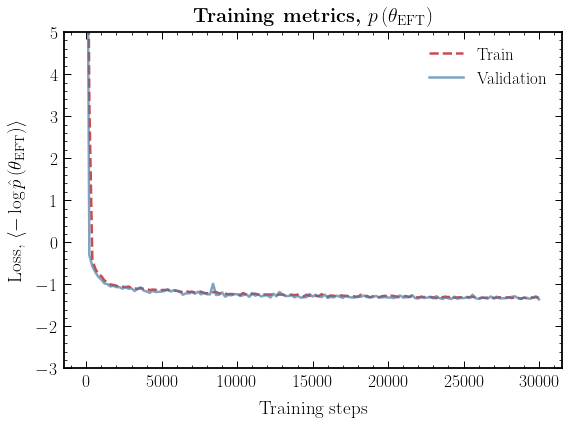

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-3, 5)

plt.tight_layout()
plt.savefig("figures/loss_p_eft.pdf")

In [50]:
samples = flow.sample(num_samples=100_000)

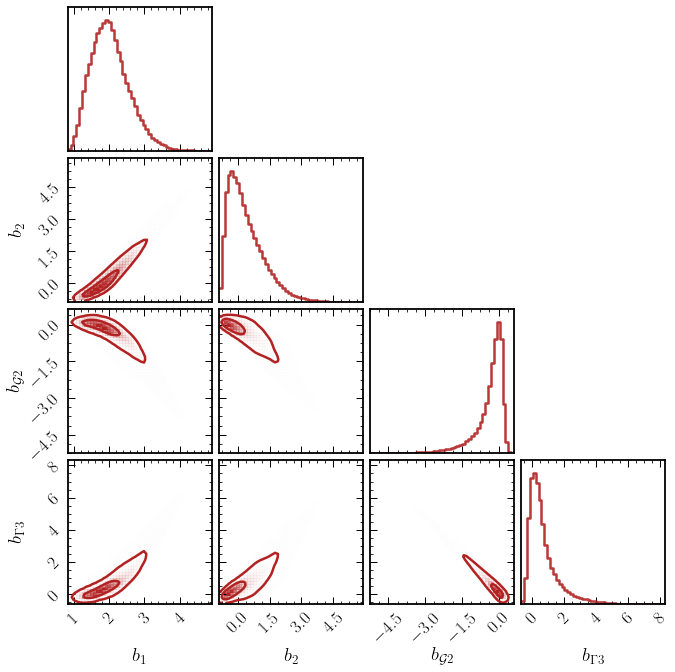

In [51]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.75,
    "smooth1d": 0.5,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "labels": [r'$b_1$', r'$b_2$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$',]
}

fig = corner.corner(samples.detach().numpy(), **corner_configs, color='firebrick');

In [52]:
torch.save(flow, "../data/models/p_beta.pt")